In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd 
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord 
from astropy.wcs import WCS
from Finder import *
import time
Z = ZScaleInterval()
s = time.time()

/home/bethany/anaconda3/lib/python3.7/site-packages/SecretStorage-2.3.1-py3.7.egg/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
/home/bethany/anaconda3/lib/python3.7/site-packages/SecretStorage-2.3.1-py3.7.egg/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead


In [2]:
def get_file(id,galaxy,segment=1,extension=1,filter='um2'):
    # Change where SWIFT data is stored
    file_location = "/media/bethany/Seagate Portable Drive"
    # Below is automatic.
    labels = ['RAhr','DEdeg','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','Imag','e_Imag','Flag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag']
    fname = glob.glob(f"{file_location}/SwiftData/Astrometry/{galaxy}/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.new")
    cname = glob.glob(f"{file_location}/SwiftData/Astrometry/{galaxy}/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.full.dat")
    HDR = fits.open(fname[0])
    CAT = pd.read_csv(cname[0],delimiter='\s+',names=labels)
    return HDR,CAT
def get_source_info(source_name):
    if 'lmc' in source_name:
        cname = 'LMC_specsample_1_1_cross.csv'
    elif 'smc' in source_name:
        cname = 'SMC_specsample_1_1_cross.csv'
    df = pd.read_csv(cname)
    return df[df.name == source_name]

In [3]:
def find_nearby_sources(source_name,n_arcseconds):
    # Open the correct catalog
    if 'lmc' in source_name:
        cname = 'LMC_specsample_1_1_cross.csv'
        uname = '../../Data/UV/LMC_combined_1_1.csv'
    elif 'smc' in source_name:
        cname = 'SMC_specsample_1_1_cross.csv'
        uname = '../../Data/UV/SMC_combined_1_1.csv'
    df1 = pd.read_csv(cname)
    df2 = pd.read_csv(uname)
    target  = df1[df1.name == source_name]
    # Search for all sources within range of target
    co = SkyCoord(target.ra,target.dec,unit=u.deg)[0]
    cos = SkyCoord(df2.ra,df2.dec,unit=u.deg)
    seps = co.separation(cos).arcsecond
    nearby = df2[seps < n_arcseconds]
    nearby['Separation_in_as'] = seps[seps < n_arcseconds]
    return nearby[nearby.name != source_name]

# lmc-835

In [4]:
# Get info on source from UV catalog 
source_name = 'lmc-obs45578-835'
obs_id = '45578'
galaxy = 'LMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in LMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc119.5.map.bz2
Chosen Star is 0.817607776891313 from source in LMC119.5
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55994.634190 from DATE-OBS.
Set MJD-END to 55994.635972 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55994.634190 from DATE-OBS.
Set MJD-END to 55994.635972 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55994.634190 from DATE-OBS.
Set MJD-END to 55994.635972 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


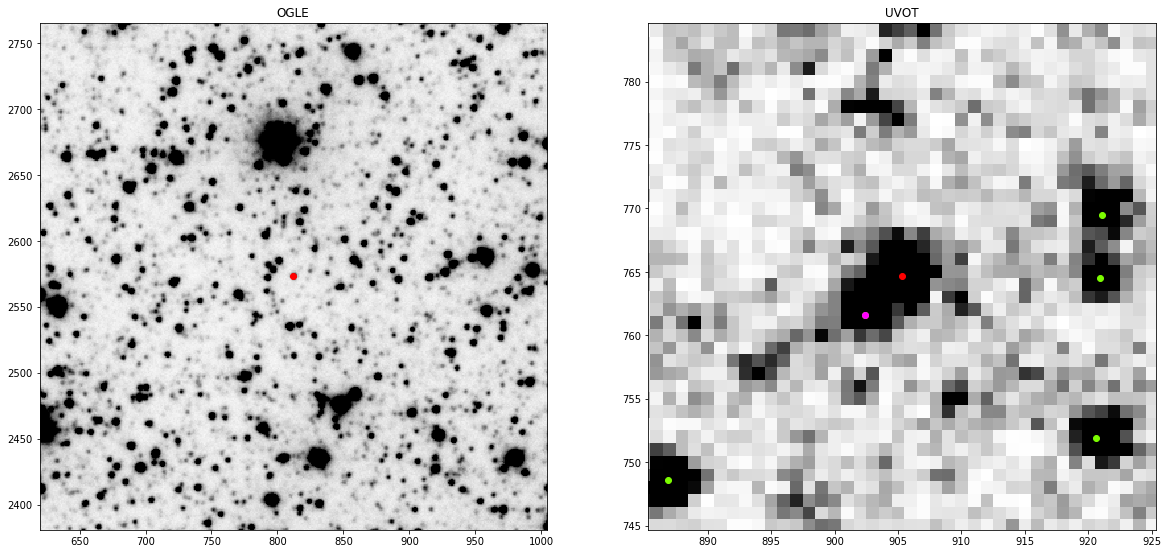

In [5]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')
x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')


x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')



ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [6]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
4,lmc_survey_164-97,lmc-obs45578-835,45578,76.194645,-69.04014,15.748439,0.066845,15.951021,0.083496,16.239399,...,0.128836,0.092557,10,912.3578,773.901644,905.309862,764.679124,906.878255,764.593221,0.817608


In [7]:
# Within 5 - Magenta
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
420978,lmc-obs45578-844,45578,76.196925,-69.04099,17.010551,0.125249,17.098221,0.156813,17.198023,0.162083,...,12344.0,909.420614,770.870487,12307.0,902.371762,761.644966,12275.0,903.940672,761.560909,4.240759


In [8]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
420822,lmc-obs45578-688,45578,76.166625,-69.04079,17.277905,0.149362,17.432653,0.196426,17.196800,0.161520,...,11015.0,948.273154,771.417538,10986.0,941.243152,762.198811,10952.0,942.794312,762.110737,36.158570
420856,lmc-obs45578-722,45578,76.173030,-69.04466,17.206255,0.142553,17.323997,0.182802,17.278297,0.171662,...,11312.0,939.993128,757.598850,11280.0,932.960596,748.367425,11246.0,934.511791,748.286911,32.239938
420857,lmc-obs45578-723,45578,76.173600,-69.03876,18.317541,0.329228,18.139753,0.335073,17.969730,0.292424,...,11336.0,939.365694,778.726010,11304.0,932.330222,769.511919,11270.0,933.887516,769.420983,27.553541
420872,lmc-obs45578-738,45578,76.176045,-69.04822,17.368460,0.158617,17.311647,0.181490,17.488285,0.199147,...,11459.0,936.066342,744.868775,11425.0,929.033418,735.627274,11392.0,930.583005,735.553324,37.677893
420901,lmc-obs45578-767,45578,76.182375,-69.03877,17.358391,0.158063,17.451351,0.199567,17.605200,0.219557,...,11727.0,928.113633,778.739872,11692.0,921.072539,769.523905,11659.0,922.635018,769.433994,16.553240
420902,lmc-obs45578-768,45578,76.182450,-69.04016,17.499996,0.174837,17.585907,0.219903,17.776382,0.251617,...,11729.0,927.993799,773.763965,11694.0,920.953316,764.543621,11661.0,922.514469,764.456236,15.704510
420903,lmc-obs45578-769,45578,76.182525,-69.04706,17.324915,0.153575,17.060446,0.153480,17.470209,0.199507,...,11732.0,927.780345,749.059177,11697.0,920.742965,739.819177,11664.0,922.297498,739.744050,29.396146
420905,lmc-obs45578-771,45578,76.182660,-69.04369,17.240877,0.145607,17.120296,0.159422,17.293488,0.175443,...,11741.0,927.664529,761.126632,11706.0,920.625553,751.895778,11673.0,922.183393,751.814737,20.037359
420906,lmc-obs45578-772,45578,76.182900,-69.03152,16.049183,0.074981,16.134212,0.090723,16.194269,0.087658,...,11747.0,927.563855,804.695592,11712.0,920.518855,795.504482,11679.0,922.088938,795.401229,34.522980
420927,lmc-obs45578-793,45578,76.186545,-69.04642,17.195982,0.140487,17.114979,0.159071,17.215010,0.166367,...,11902.0,922.638203,751.373077,11867.0,915.598122,742.133920,11834.0,917.155649,742.058201,24.897689


# lmc-2273

In [9]:
# Get info on source from UV catalog 
source_name = 'lmc-obs45461-2273'
obs_id = '45461'
galaxy = 'LMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in LMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc119.4.map.bz2
Chosen Star is 0.34172173219042695 from source in LMC119.4
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56264.657870 from DATE-OBS.
Set MJD-END to 56264.662662 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56264.657870 from DATE-OBS.
Set MJD-END to 56264.662662 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56264.657870 from DATE-OBS.
Set MJD-END to 56264.662662 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


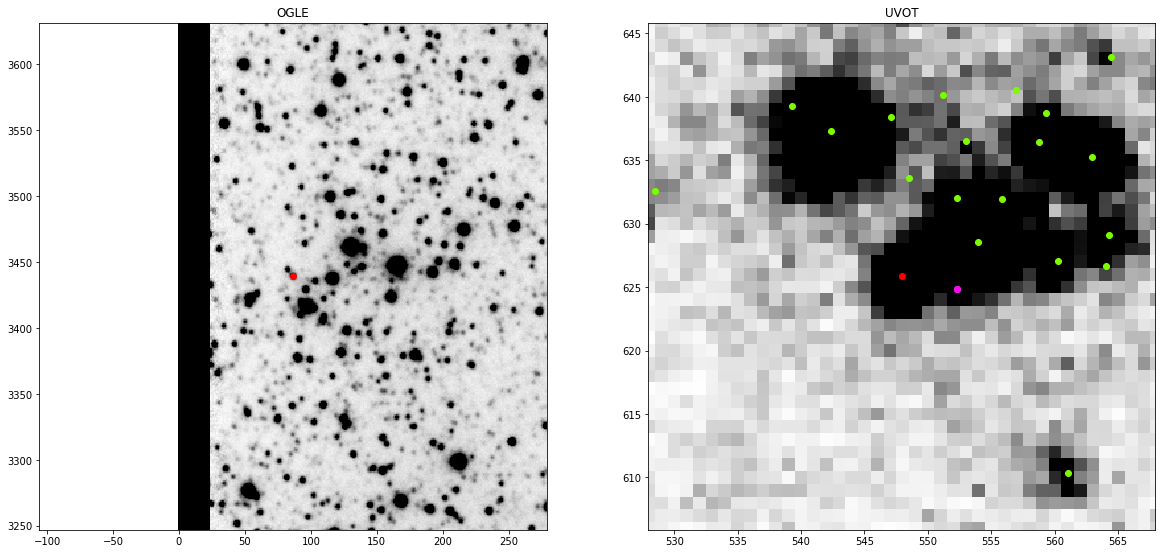

In [10]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')
x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')


x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')



ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [11]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
14,lmc-m04,lmc-obs45461-2273,45461,77.205735,-69.0916,15.964259,0.054118,16.078821,0.062557,16.361624,...,0.307072,0.332938,10,555.746008,639.196503,547.948961,625.881969,548.50703,624.866812,0.0444


In [12]:
# Within 5 - Magenta
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
95800,lmc-obs45461-2257,45461,77.20233,-69.09188,17.111048,0.084085,17.538538,0.130273,17.531704,0.116823,...,18660.0,560.102179,638.20189,18584.0,552.305433,624.883361,18614.0,552.860893,623.870869,4.489177


In [13]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
95687,lmc-obs45461-2144,45461,77.183370,-69.09052,17.338121,0.096773,17.561600,0.130900,17.521847,0.116396,...,17990.0,584.332477,643.120369,17912.0,576.548672,629.781028,17943.0,577.086185,628.779871,28.995987
95693,lmc-obs45461-2150,45461,77.184885,-69.09851,18.271503,0.180339,18.619989,0.281883,18.340296,0.212637,...,18043.0,582.457590,614.479965,17965.0,574.643483,601.140500,17996.0,575.191782,600.149005,36.553167
95744,lmc-obs45461-2201,45461,77.192940,-69.09071,17.257555,0.091393,17.235695,0.107365,17.320143,0.101672,...,18323.0,572.098273,642.418306,18247.0,564.309546,629.089574,18277.0,564.855508,628.082010,16.748037
95748,lmc-obs45461-2205,45461,77.193990,-69.08898,15.666904,0.050708,15.775654,0.057034,15.810870,0.052915,...,18358.0,570.741398,648.616121,18282.0,562.958522,635.289387,18312.0,563.503338,634.278917,17.795490
95756,lmc-obs45461-2213,45461,77.195505,-69.09594,17.729599,0.122068,18.084215,0.189012,17.750427,0.135969,...,18409.0,568.862208,623.667189,18333.0,561.053471,610.339941,18363.0,561.607898,609.337474,20.416007
95760,lmc-obs45461-2217,45461,77.196090,-69.09127,17.121510,0.084601,17.105595,0.099582,17.230392,0.096068,...,18432.0,568.075388,640.403773,18356.0,560.283312,627.078369,18386.0,560.832654,626.069355,12.448323
95770,lmc-obs45461-2227,45461,77.197290,-69.08866,16.889372,0.075083,16.842632,0.086304,16.765755,0.074447,...,18476.0,566.518994,649.755093,18400.0,558.735853,636.432241,18430.0,559.283126,635.419115,15.157610
95783,lmc-obs45461-2240,45461,77.199570,-69.08991,NaN,NaN,17.764208,0.151953,17.994524,0.163412,...,NaN,NaN,NaN,18482.0,555.825618,631.948611,18512.0,556.376340,630.935494,9.987690
95784,lmc-obs45461-2241,45461,77.199660,-69.09869,18.769823,0.265955,18.839746,0.338418,NaN,NaN,...,18562.0,563.573936,613.799933,18486.0,555.753838,600.477357,NaN,NaN,NaN,26.690272
95790,lmc-obs45461-2247,45461,77.201055,-69.09084,13.956743,0.042965,13.987922,0.044030,14.027061,0.043111,...,18597.0,561.723412,641.932607,18521.0,553.930879,628.613006,18551.0,554.483992,627.600053,6.605957


# lmc-4349

In [14]:
# Get info on source from UV catalog 
source_name = 'lmc-obs45516-4349'
obs_id = '45516'
galaxy = 'LMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in LMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc162.2.map.bz2
Chosen Star is 12.414412209631461 from source in LMC162.2
Chosen Star not close enough to subfield. Recalculating
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc162.1.map.bz2
Chosen Star is 0.5636232425300901 from source in LMC162.1
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56358.960903 from DATE-OBS.
Set MJD-END to 56358.962708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56358.960903 from DATE-OBS.
Set MJD-END to 56358.962708 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56358.960903 from DATE-OBS.
Set MJD-END to 56358.962708 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


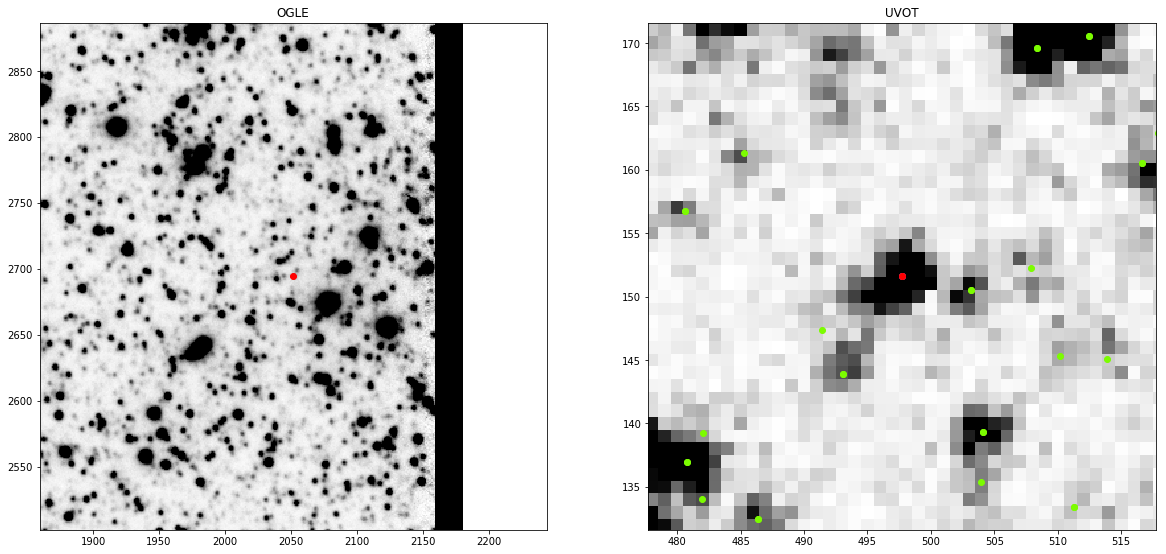

In [15]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')

x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')

x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')

ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [16]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
34,lmc-obs45516-4349,lmc-obs45516-4349,45516,82.004805,-69.99687,16.271029,0.083707,16.345757,0.102788,16.515699,...,0.228027,0.1911,0,505.158663,159.384071,497.720746,151.624527,497.994149,151.135152,0.035967


In [17]:
# Within 5 - Magenta ---- note there may be a duplicate here. (!!!!!!!!!!!!!!)
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
302876,lmc-obs45526-488,45526,82.004805,-69.99687,16.143135,0.057352,16.360273,0.069402,16.561129,0.072074,...,14041.0,939.442717,1093.41662,13792.0,938.155688,1087.003383,13796.0,938.89647,1088.005096,0.0


In [18]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
268975,lmc-obs45516-4142,45516,81.974250,-69.99535,16.286022,0.084066,16.169247,0.093939,16.290802,0.088774,...,31539.0,542.615552,164.921390,31559.0,535.184946,157.127745,31589.0,535.445809,156.617679,38.024341
268979,lmc-obs45516-4146,45516,81.974820,-69.99849,15.603364,0.063423,15.573405,0.072112,15.604174,0.065089,...,31567.0,541.911146,153.653507,31587.0,534.482526,145.874007,31617.0,534.747862,145.368210,37.381549
268985,lmc-obs45516-4152,45516,81.975540,-69.99365,18.009180,0.263974,17.762699,0.263703,18.182133,0.345155,...,31614.0,541.037089,171.017908,31634.0,533.604985,163.218097,31664.0,533.864016,162.706667,37.859682
269001,lmc-obs45516-4168,45516,81.977595,-69.99193,16.983942,0.125654,17.109762,0.165209,16.853014,0.124520,...,31718.0,538.520380,177.184252,31738.0,531.086576,169.378913,31768.0,531.344045,168.866527,37.938365
269031,lmc-obs45516-4198,45516,81.983265,-69.99046,NaN,NaN,17.737957,0.263245,18.025883,0.305226,...,NaN,NaN,NaN,32016.0,524.133965,174.637851,32046.0,524.391496,174.126949,35.161413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305955,lmc-obs45526-3567,45526,82.021965,-70.00510,18.946638,0.307241,NaN,NaN,NaN,NaN,...,14829.0,918.254926,1064.076470,NaN,NaN,NaN,NaN,NaN,NaN,36.389497
305956,lmc-obs45526-3568,45526,82.022310,-70.00299,18.976654,0.317224,NaN,NaN,NaN,NaN,...,14847.0,917.867226,1071.613584,NaN,NaN,NaN,NaN,NaN,NaN,30.821458
305966,lmc-obs45526-3578,45526,82.033710,-69.99288,18.407749,0.207156,NaN,NaN,NaN,NaN,...,15340.0,904.053296,1107.749420,NaN,NaN,NaN,NaN,NaN,NaN,38.387372
306525,lmc-obs45526-4137,45526,82.017645,-70.00177,NaN,NaN,NaN,NaN,18.793535,0.347669,...,NaN,NaN,NaN,NaN,NaN,NaN,14365.0,923.114399,1070.518426,23.688128


# lmc-206

In [19]:
# Get info on source from UV catalog 
source_name = 'lmc-obs45446-206'
obs_id = '45446'
galaxy = 'LMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in LMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc183.4.map.bz2
Chosen Star is 17.550027138115226 from source in LMC183.4
Chosen Star not close enough to subfield. Recalculating
http://www.astrouw.edu.pl/ogle/ogle3/maps/lmc/maps/lmc183.3.map.bz2
Chosen Star is 0.35709097694181857 from source in LMC183.3
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55778.316817 from DATE-OBS.
Set MJD-END to 55778.321250 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55778.316817 from DATE-OBS.
Set MJD-END to 55778.321250 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55778.316817 from DATE-OBS.
Set MJD-END to 55778.321250 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


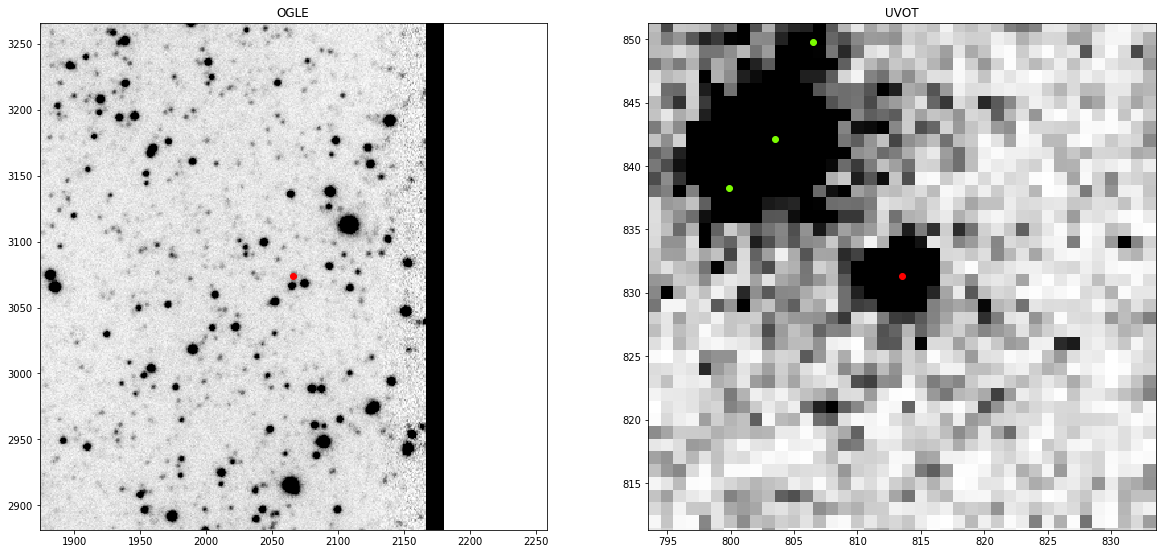

In [20]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')

x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')

x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')

ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [21]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
47,lmc-obs45446-206,lmc-obs45446-206,45446,86.86671,-69.1021,16.498672,0.05973,16.613071,0.071471,16.892548,...,0.127151,0.10271,10,815.911241,842.02883,813.502842,831.329486,813.384513,831.905966,0.040057


In [22]:
# Within 5 - Magenta 
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as


In [23]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
48639,lmc-obs45446-200,45446,86.859480,-69.09488,18.796181,0.198923,18.686989,0.228416,18.857845,0.218223,...,2247.0,825.169146,867.854986,2207.0,822.779944,857.200912,2208.0,822.666609,857.762400,27.600914
48646,lmc-obs45446-207,45446,86.867700,-69.09447,16.617315,0.061637,16.655361,0.072345,16.674044,0.061281,...,2299.0,814.663366,869.338284,2259.0,812.267433,858.680899,2260.0,812.160498,859.243360,27.497414
48651,lmc-obs45446-212,45446,86.872215,-69.09694,19.001841,0.234927,18.896358,0.264604,18.858553,0.221383,...,2335.0,808.887316,860.506721,2295.0,806.483086,849.832171,2296.0,806.375862,850.400175,19.875928
48653,lmc-obs45446-214,45446,86.874540,-69.09908,14.106516,0.043207,13.961300,0.043993,14.016588,0.042693,...,2357.0,805.911766,852.851793,2316.0,803.501836,842.163763,2317.0,803.393244,842.736247,14.809208
48657,lmc-obs45446-218,45446,86.877360,-69.10016,17.753702,0.101967,17.958813,0.139982,17.944353,0.116483,...,2375.0,802.305989,848.991168,2334.0,799.891801,838.295392,2335.0,799.783680,838.870506,15.356641
48667,lmc-obs45446-228,45446,86.887725,-69.10890,NaN,NaN,18.950064,0.281332,19.026392,0.258583,...,NaN,NaN,NaN,2418.0,786.612455,806.976511,2419.0,786.499416,807.570373,36.432016
49292,lmc-obs45446-853,45446,86.862165,-69.11065,19.227844,0.279287,NaN,NaN,19.022671,0.249088,...,2265.0,821.695980,811.415895,NaN,NaN,NaN,2226.0,819.143079,801.267506,31.328238


# smc-981

In [24]:
# Get info on source from UV catalog 
source_name = 'smc-obs40427-981'
obs_id = '40427'
galaxy = 'SMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in SMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/smc/maps/smc105.3.map.bz2
Chosen Star is 0.3317733998387642 from source in SMC105.3
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55813.668854 from DATE-OBS.
Set MJD-END to 55813.670579 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55813.668854 from DATE-OBS.
Set MJD-END to 55813.670579 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55813.668854 from DATE-OBS.
Set MJD-END to 55813.670579 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


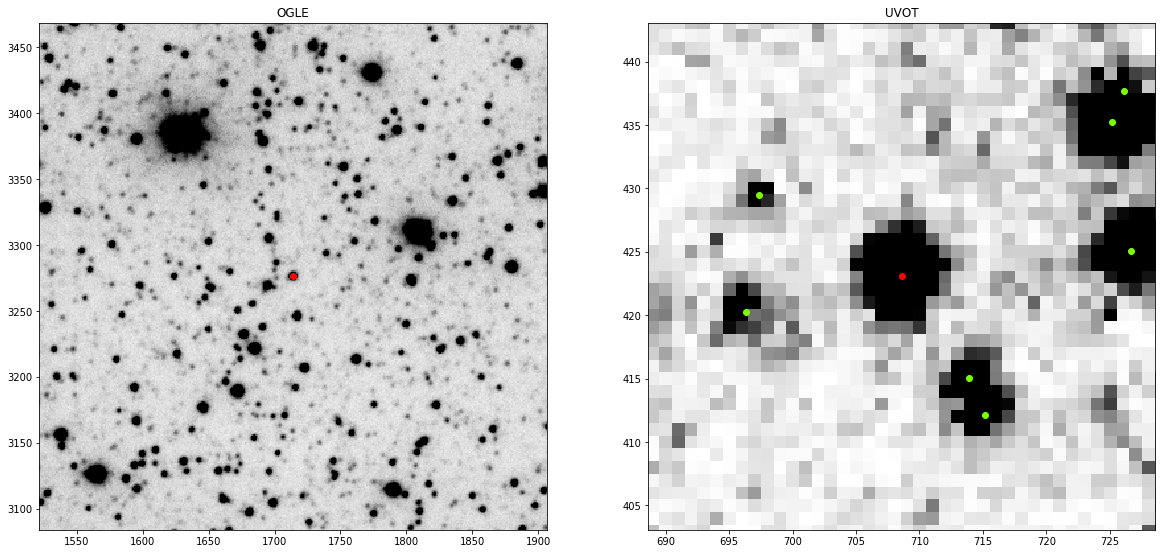

In [25]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')

x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')

x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')

ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [26]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
5,smc-a18,smc-obs40427-981,40427,15.24876,-72.62048,14.451388,0.049424,14.592916,0.054514,14.894846,...,0.078909,0.0745,20.0,713.453696,417.532786,708.597183,423.073685,707.944568,422.638175,0.010938


In [27]:
# Within 5 - Magenta 
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as


In [28]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
67753,smc-obs40427-876,40427,15.214725,-72.61840,16.510784,0.088175,16.389143,0.098561,16.832350,0.110117,...,8021.0,749.889779,424.914435,7994.0,745.054974,430.460552,8027.0,744.382391,430.018444,37.358721
67759,smc-obs40427-882,40427,15.216345,-72.62143,17.763931,0.185086,17.776855,0.225639,18.295937,0.308990,...,8067.0,748.129346,414.056469,8041.0,743.295059,419.599652,8074.0,742.621411,419.162120,35.022920
67764,smc-obs40427-887,40427,15.219900,-72.61739,17.427790,0.149860,17.659744,0.207568,17.652382,0.187190,...,8136.0,744.360800,428.547631,8108.0,739.521898,434.094157,8141.0,738.853268,433.651092,32.969683
67766,smc-obs40427-889,40427,15.220890,-72.62614,17.749880,0.183807,17.377123,0.171978,17.797222,0.212388,...,8158.0,743.226346,397.182347,8130.0,738.391283,402.720396,8163.0,737.717291,402.290194,36.235991
67771,smc-obs40427-894,40427,15.222015,-72.61809,17.417452,0.148655,17.305870,0.164577,17.577215,0.178141,...,8179.0,742.091425,426.043328,8151.0,737.251451,431.589043,8184.0,736.583673,431.147218,30.020698
67781,smc-obs40427-904,40427,15.224925,-72.62550,15.070362,0.054589,15.173461,0.062322,15.168695,0.056891,...,8254.0,738.915752,399.486084,8225.0,734.077467,405.024411,8258.0,733.406491,404.593734,31.357961
67798,smc-obs40427-921,40427,15.231900,-72.61991,15.053183,0.054499,15.157520,0.062128,15.307137,0.058857,...,8416.0,731.498748,419.541464,8385.0,726.653001,425.084588,8418.0,725.990207,424.646459,18.245919
67799,smc-obs40427-922,40427,15.232395,-72.61639,17.808748,0.200850,18.338896,0.344524,17.626432,0.184489,...,8428.0,730.996767,432.161099,8397.0,726.149091,437.707301,8430.0,725.488952,437.263997,22.946505
67803,smc-obs40427-926,40427,15.233340,-72.61708,14.973240,0.053756,14.953059,0.058906,15.190385,0.057098,...,8459.0,729.979976,429.689675,8427.0,725.131999,435.235191,8460.0,724.471991,434.793008,20.610995
67806,smc-obs40427-929,40427,15.234435,-72.61459,18.332626,0.306171,18.296579,0.334894,NaN,NaN,...,8477.0,728.827392,438.618101,8444.0,723.977599,444.165605,NaN,NaN,NaN,26.210094


# smc-6198

In [29]:
# Get info on source from UV catalog 
source_name = 'smc-obs40416-6198'
obs_id = '40416'
galaxy = 'SMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in SMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/smc/maps/smc105.5.map.bz2
Chosen Star is 26.382555931484934 from source in SMC105.5
Chosen Star not close enough to subfield. Recalculating
http://www.astrouw.edu.pl/ogle/ogle3/maps/smc/maps/smc105.6.map.bz2
Chosen Star is 0.2509679562255579 from source in SMC105.6
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55465.666146 from DATE-OBS.
Set MJD-END to 55465.668854 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55465.666146 from DATE-OBS.
Set MJD-END to 55465.668854 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55465.666146 from DATE-OBS.
Set MJD-END to 55465.668854 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


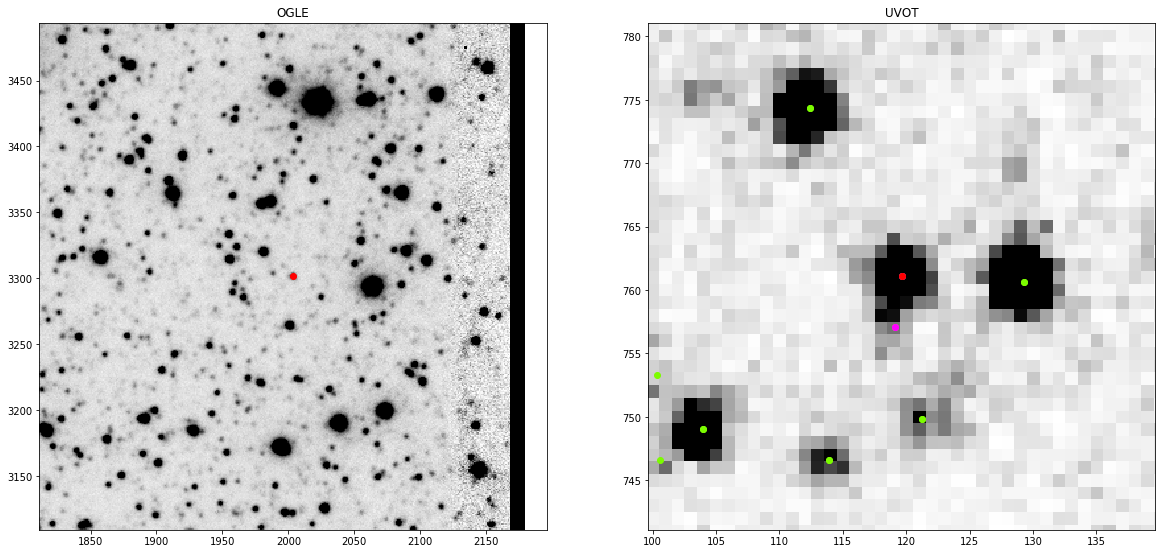

In [30]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')

x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')

x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')

ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [31]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
2,smc-m2,smc-obs40416-6198,40416,14.25651,-72.60092,16.152695,0.064551,16.32217,0.081165,16.784935,...,0.109002,0.15651,20.0,114.605529,764.044874,119.635782,761.091749,119.908869,762.06148,0.010949


In [32]:
# Within 5 - Magenta 
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
13656,smc-obs40416-7769,40416,14.257095,-72.60203,NaN,NaN,NaN,NaN,18.527231,0.309067,...,NaN,NaN,NaN,NaN,NaN,NaN,41810.0,119.332250,758.076923,4.045315
46880,smc-obs40423-529,40423,14.256510,-72.60092,16.273661,0.056331,16.455219,0.068793,16.970840,0.077701,...,7817.0,1029.331023,657.571493,7484.0,1034.760595,658.422913,7467.0,1034.898249,656.890371,0.000000
46884,smc-obs40423-533,40423,14.257095,-72.60203,18.411963,0.185988,18.686462,0.297619,18.788015,0.288647,...,7831.0,1028.682540,653.595245,7498.0,1034.114368,654.446801,7481.0,1034.249073,652.917000,4.045315


In [33]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
12034,smc-obs40416-6147,40416,14.225250,-72.60155,17.261705,0.105473,17.142353,0.121464,17.164450,0.110009,...,41242.0,148.043715,762.019677,40842.0,153.179193,759.216550,40865.0,153.430505,760.194956,33.726883
12070,smc-obs40416-6183,40416,14.247525,-72.60108,15.768662,0.057062,15.663039,0.062748,15.990974,0.062570,...,41910.0,124.215735,763.539869,41505.0,129.276457,760.629980,41528.0,129.543298,761.602240,9.689371
12077,smc-obs40416-6190,40416,14.250135,-72.59041,15.683767,0.055751,15.604986,0.061417,15.866626,0.060050,...,41985.0,121.104047,801.735721,41579.0,125.992210,798.840778,41603.0,126.268715,799.798611,38.453689
12082,smc-obs40416-6195,40416,14.255175,-72.60407,17.901535,0.169916,17.953552,0.218264,18.293396,0.253961,...,42133.0,116.128868,752.773123,41727.0,121.211405,749.817992,41750.0,121.481395,750.792131,11.430684
12089,smc-obs40416-6202,40416,14.259480,-72.59358,14.909236,0.048396,14.834049,0.051540,15.152157,0.050651,...,42276.0,111.204954,790.310493,41869.0,116.113027,787.362363,41892.0,116.393509,788.321891,26.616798
12096,smc-obs40416-6209,40416,14.262030,-72.60495,18.040083,0.190061,17.829119,0.199464,18.243799,0.244144,...,42353.0,108.829388,749.568893,41946.0,113.903662,746.577898,41969.0,114.177725,747.551354,15.677509
12098,smc-obs40416-6211,40416,14.263110,-72.59720,15.961254,0.060757,15.791265,0.066012,16.109949,0.065497,...,42392.0,107.434790,777.317282,41985.0,112.387155,774.342041,42008.0,112.667427,775.305264,15.160308
12107,smc-obs40416-6220,40416,14.266830,-72.59158,18.193411,0.215806,17.659191,0.181391,17.891405,0.187039,...,42510.0,103.282194,797.416107,42103.0,108.136050,794.437668,42125.0,108.423100,795.392723,35.412656
12115,smc-obs40416-6228,40416,14.271240,-72.60423,16.440487,0.072261,16.559334,0.090850,16.781803,0.088597,...,42656.0,98.963703,752.075931,42249.0,103.997519,749.041922,42271.0,104.278353,750.011967,19.833818
12119,smc-obs40416-6232,40416,14.275800,-72.60887,16.909243,0.089220,16.901182,0.107086,17.089550,0.103952,...,42790.0,94.238204,735.422059,42383.0,99.327571,732.352573,42403.0,99.608393,733.327291,35.357043


# smc-4332

In [34]:
# Get info on source from UV catalog 
source_name = 'smc-obs40454-4332'
obs_id = '40454'
galaxy = 'SMC' 
########################################################################
source = get_source_info(source_name)
co = SkyCoord(source.ra,source.dec,unit=u.deg)[0]
# Pull the Swift image and related MCPS catalog
hdr, cat = get_file(obs_id,galaxy)
# Find the right OGLE image and get it from their website - note this line takes around 30 seconds.
ogle = Ogle(co.ra.deg,co.dec.deg)
# For Plot Formatting
ovmin,ovmax = Z.get_limits(ogle.image.data)
svmin,svmax = Z.get_limits(hdr[0].data)
# Get info on nearby sources --- > This takes around 20 seconds each also. 
within5 = find_nearby_sources(source_name,5)
within40 = find_nearby_sources(source_name,40)
within40.to_csv(f'{source_name}_nearbyobjects.csv')

Target found in SMC
http://www.astrouw.edu.pl/ogle/ogle3/maps/smc/maps/smc113.7.map.bz2
Chosen Star is 0.43248102659507903 from source in SMC113.7
Finder Chart Aquired


/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55890.873634 from DATE-OBS.
Set MJD-END to 55890.877627 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55890.873634 from DATE-OBS.
Set MJD-END to 55890.877627 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55890.873634 from DATE-OBS.
Set MJD-END to 55890.877627 from DATE-END'. [astropy.wcs.wcs]


Image width set to 50 arcseconds


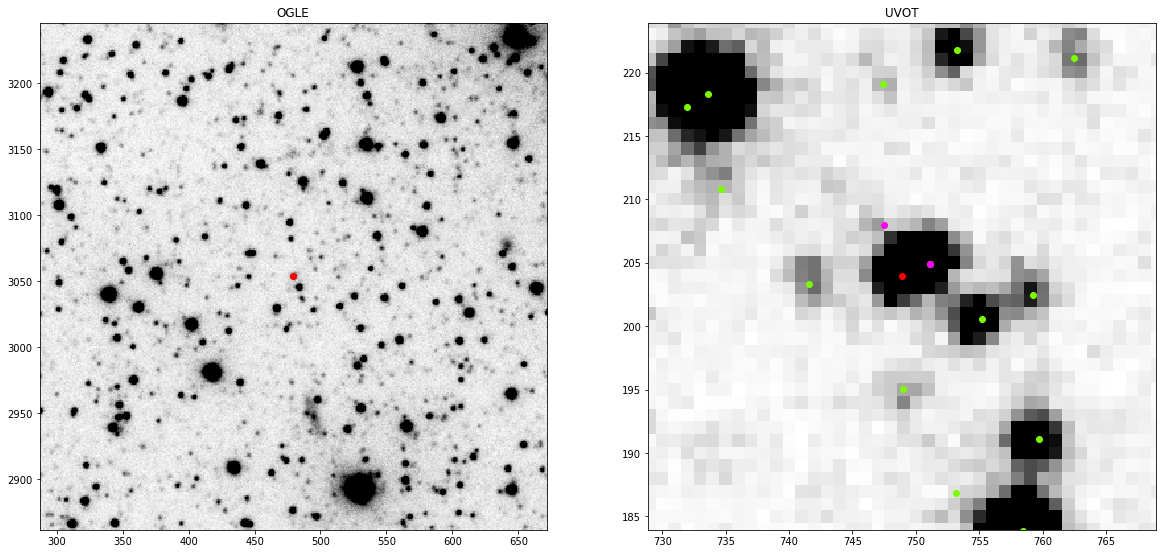

In [35]:
f, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(ogle.image.data,origin='lower',vmin=ovmin,vmax=ovmax,cmap='Greys')
axes[0].scatter(ogle.X,ogle.Y,c='r')

axes[1].imshow(hdr[0].data,origin='lower',vmin=svmin,vmax=svmax,cmap='Greys')

x40,y40 = SkyCoord(within40.ra,within40.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x40,y40,c='lawngreen')


x5,y5 = SkyCoord(within5.ra,within5.dec,unit=u.deg).to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x5,y5,c='magenta')

x,y = co.to_pixel(WCS(hdr[0].header),origin=0)
axes[1].scatter(x,y,c='r')

ogle_pix_scale = 0.26 # arcsec/pixel source: https://microlensing-source.org/ground-based-surveys/
uvot_pix_scale = 2.5
n=50 #arcsecond width
axes[0].set_xlim(ogle.X-n/ogle_pix_scale,ogle.X+n/ogle_pix_scale)
axes[0].set_ylim(ogle.Y-n/ogle_pix_scale,ogle.Y+n/ogle_pix_scale)
axes[1].set_xlim(x-n/uvot_pix_scale,x+n/uvot_pix_scale)
axes[1].set_ylim(y-n/uvot_pix_scale,y+n/uvot_pix_scale)
axes[0].set_title('OGLE')
axes[1].set_title('UVOT')
print(f"Image width set to {n} arcseconds")

In [36]:
source

,#Name,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,...,uvm2_resid_frac,uvw1_resid_frac,mcps_flag,uvw2_pix_x,uvw2_pix_y,uvm2_pix_x,uvm2_pix_y,uvw1_pix_x,uvw1_pix_y,Separation
10,smc-m1,smc-obs40454-4332,40454,16.001985,-72.27852,16.122719,0.057541,16.16958,0.066508,16.420031,...,0.188368,0.231487,10.0,751.960354,216.781063,748.886096,203.938831,749.640868,203.599793,0.002


In [37]:
# Within 5 - Magenta 
within5

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
216665,smc-obs40454-4316,40454,15.99996,-72.27824,16.823889,0.074279,16.72377,0.08392,17.549187,0.242957,...,15386.0,754.176014,217.780882,15197.0,751.100678,204.937152,15177.0,751.853513,204.599545,2.437236
221003,smc-obs40454-8654,40454,16.00332,-72.27739,18.798632,0.276971,NaN,NaN,NaN,NaN,...,15485.0,750.511966,220.845936,NaN,NaN,NaN,NaN,NaN,NaN,4.323058


In [38]:
# Within 40 - Green
within40

,name,obsid,ra,dec,uvw2_mag,uvw2_mag_err,uvm2_mag,uvm2_mag_err,uvw1_mag,uvw1_mag_err,...,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y,Separation_in_as
95809,smc-obs40431-6570,40431,15.968790,-72.27808,18.607296,0.236768,18.496286,0.256311,18.663275,0.259668,...,25350.0,148.576794,355.459490,25053.0,148.634747,346.262007,25121.0,147.314325,347.189703,36.410145
95812,smc-obs40431-6573,40431,15.968865,-72.27897,17.245430,0.091764,17.470350,0.123575,17.521229,0.110781,...,25353.0,148.516023,352.268397,25056.0,148.575048,343.069696,25124.0,147.253997,344.000491,36.328743
97072,smc-obs40431-7833,40431,15.969000,-72.27465,18.746746,0.265264,NaN,NaN,18.648924,0.255309,...,25358.0,148.266047,367.752718,NaN,NaN,NaN,25129.0,147.001528,359.476173,38.740757
216268,smc-obs40454-3919,40454,15.968790,-72.27808,18.600006,0.233092,18.284788,0.226967,NaN,NaN,...,14429.0,788.242360,218.245718,14242.0,785.148352,205.417664,NaN,NaN,NaN,36.410145
216272,smc-obs40454-3923,40454,15.968865,-72.27897,17.331413,0.096128,17.575369,0.136609,17.586590,0.252185,...,14434.0,788.150631,215.047663,14247.0,785.056056,202.227559,14227.0,785.787313,201.919677,36.328743
216275,smc-obs40454-3926,40454,15.969000,-72.27465,18.774355,0.268449,18.731144,0.322265,NaN,NaN,...,14439.0,788.050260,230.572181,14252.0,784.958750,217.713761,NaN,NaN,NaN,38.740757
216312,smc-obs40454-3963,40454,15.971370,-72.27911,18.319708,0.187366,18.724075,0.321000,NaN,NaN,...,14517.0,785.411542,214.554220,14329.0,782.318382,201.733897,NaN,NaN,NaN,33.614691
216504,smc-obs40454-4155,40454,15.985800,-72.26936,17.875954,0.134578,18.044516,0.189940,NaN,NaN,...,14974.0,769.740116,249.641772,14787.0,766.661724,236.728972,NaN,NaN,NaN,37.444965
216544,smc-obs40454-4195,40454,15.989595,-72.27371,17.797583,0.127798,18.131681,0.201837,NaN,NaN,...,15080.0,765.548448,234.024931,14893.0,762.469550,221.146796,NaN,NaN,NaN,22.005176
216575,smc-obs40454-4226,40454,15.992070,-72.28210,16.652740,0.069095,16.731451,0.083980,16.949085,0.167699,...,15166.0,762.760340,203.883273,14978.0,759.677997,191.078737,14958.0,760.431531,190.754014,16.855966


In [39]:
print(time.time() - s)

340.4163475036621
